In [1]:
kpoison=0.75

In [2]:
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import os
import joblib
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, roc_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, IsolationForest

from functools import reduce

from datetime import datetime
from datetime import datetime, timedelta
from time import time

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree

from datetime import datetime
from datetime import datetime, timedelta
from time import time
from timeit import default_timer as timer
#start = timer()
#end = timer()
#print(end - start) 

import random

In [3]:
def under_sampling(original_features, original_labels):

    X = original_features
    y = original_labels
    undersample = RandomUnderSampler(sampling_strategy=0.8)
    X_under, y_under = undersample.fit_resample(X, y)
    malware_undersampled = X_under
    malware_undersampled['Label']=y_under
    print(f"Count after undersampling: \n{malware_undersampled['Label'].value_counts()}")
    print(f"Shape of dataset: \n{malware_undersampled.shape}")
    
    undersampled_features = malware_undersampled.drop(columns = ["Label"])
    undersampled_labels = malware_undersampled.Label

    return undersampled_features, undersampled_labels

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
  #  classes = unique_labels(y_true, y_pred)
    print('Confusion matrix')
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [5]:
def poison_lf(labels,kpoison):    
    z_train=labels
    a=0;b=0; #just indicators 
    #kpoison=0.5
    rate_poison=round(kpoison*y_train.shape[0]);
    for l in range(0,rate_poison):
        location=random.randint(0,31410)
        c=z_train[location];
        if (c==0):
            z_train[location]=1
            a=a+1 #label-flipped samples for label 0
        else:
            z_train[location]=0
            b=b+1 #label flipped samples for label 1    
    print(f"The number of data poisoned is the following: \n{a+b}\n Out of a total of: \n{z_train.shape[0]}")
    #a+b=how many samples have been label flipped
    return z_train

In [6]:
def target_poison_lf(labels,feature,kpoison):    
    z_train=labels
    a=0;b=0; #just indicators 
    rate_poison=round(kpoison*y_train.shape[0]);
    for l in range(0,rate_poison):
        if (feature[l]>0):
            z_train[l]=1
            a=a+1 #label-flipped samples for label 0
        else:
            b=b+1 #label flipped samples for label 1    
    print(f"The number of POISONED data is the following: \n{a}\n The number of NON-POISONED data is the following: \n{b} \n Out of a total of: \n{z_train.shape[0]}")
    #a+b=how many samples have been label flipped
    return z_train

In [7]:
train_set = pd.read_csv('train_set.csv')
test_set = pd.read_csv('test_set.csv')
train_set.head()

,epoll_pwait epoll_pwait read,epoll_pwait read getuid,epoll_pwait read madvise,ioctl epoll_pwait read,madvise getuid epoll_pwait,read getuid epoll_pwait,read madvise getuid,epoll_pwait read futex,futex futex futex,futex futex getuid,...,fcntl64 pread64 mmap2,mmap2 gettimeofday getppid,close rt_sigprocmask gettimeofday,close gettimeofday pread64,getppid pread64 mmap2,pread64 mmap2 socket,fcntl close sendmsg,epoll_pwait ppoll recvmsg,ppoll recvmsg ioctl,Label
0,56,62,0,6,0,63,0.0,7,131,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5,3,0,1,0,4,0.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0.0,0,43,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
x_train = train_set.drop(columns = ['Label'])
y_train = train_set.Label
x_test = test_set.drop(columns = ['Label'])
y_test = test_set.Label

In [9]:
syscall_1=train_set['futex futex getuid']
syscall_1
syscall_2=train_set['epoll_pwait getuid epoll_pwait']
syscall_2
syscall_3=train_set['epoll_pwait epoll_pwait epoll_pwait']
syscall_3

0         59
1          0
2          2
3          0
4          0
        ... 
31406     37
31407     91
31408      0
31409      0
31410    183
Name: epoll_pwait epoll_pwait epoll_pwait, Length: 31411, dtype: int64

In [10]:
print(f"The ORIGINAL label vector is the following: \n{y_train}")
#y_train 
print(f"Shape of LABEL VECTOR: \n{y_train.shape[0]}")

The ORIGINAL label vector is the following: 
0        0.0
1        1.0
2        0.0
3        0.0
4        1.0
        ... 
31406    0.0
31407    0.0
31408    1.0
31409    1.0
31410    0.0
Name: Label, Length: 31411, dtype: float64
Shape of LABEL VECTOR: 
31411


In [11]:
y_train=target_poison_lf(y_train,syscall_1,kpoison)
print(f"The POISONED label vector is the following: \n{y_train}")

y_train=target_poison_lf(y_train,syscall_2,kpoison)
print(f"The POISONED label vector is the following: \n{y_train}")

y_train=target_poison_lf(y_train,syscall_3,kpoison)
print(f"The POISONED label vector is the following: \n{y_train}")

The number of POISONED data is the following: 
10643
 The number of NON-POISONED data is the following: 
12915 
 Out of a total of: 
31411
The POISONED label vector is the following: 
0        1.0
1        1.0
2        0.0
3        1.0
4        1.0
        ... 
31406    0.0
31407    0.0
31408    1.0
31409    1.0
31410    0.0
Name: Label, Length: 31411, dtype: float64
The number of POISONED data is the following: 
11471
 The number of NON-POISONED data is the following: 
12087 
 Out of a total of: 
31411
The POISONED label vector is the following: 
0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
31406    0.0
31407    0.0
31408    1.0
31409    1.0
31410    0.0
Name: Label, Length: 31411, dtype: float64
The number of POISONED data is the following: 
7774
 The number of NON-POISONED data is the following: 
15784 
 Out of a total of: 
31411
The POISONED label vector is the following: 
0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 

In [12]:
# Random Forest algorithm
rf = DecisionTreeClassifier(random_state=10)
rf.fit(x_train, y_train)

DecisionTreeClassifier(random_state=10)

Confusion matrix
[[1620 3007]
 [  33 3193]]


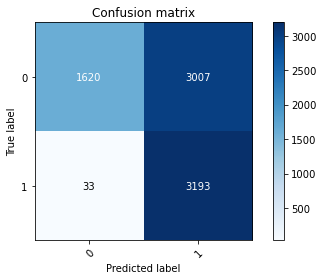

The accuracy is: 0.6128867948554693
The precision is: 0.515
The recall is: 0.9897706137631742
The f1 score is: 0.6774877997029494
The auc score is: 0.6699447406399618


In [13]:
y_predicted = rf.predict(x_test).astype(int)
plot_confusion_matrix(y_test, y_predicted, classes=unique_labels(y_test.astype(int), y_predicted), title='Confusion matrix')
plt.show()
print(f"The accuracy is: {accuracy_score(y_test, y_predicted)}")
print(f"The precision is: {precision_score(y_test, y_predicted)}")
print(f"The recall is: {recall_score(y_test, y_predicted)}")
print(f"The f1 score is: {f1_score(y_test, y_predicted)}")
print(f"The auc score is: {roc_auc_score(y_test, y_predicted)}")

In [14]:
r_probs = [0 for _ in range(len(y_test))]
rf_probs = rf.predict_proba(x_test)

In [15]:
rf_probs = rf_probs[:,1]

In [16]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

AUC SCORE

In [17]:
r_auc = roc_auc_score(y_test, r_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))

Random (chance) Prediction: AUROC = 0.500
Random Forest: AUROC = 0.670


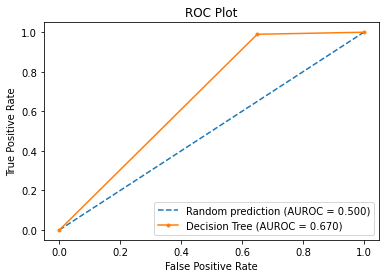

In [18]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Decision Tree (AUROC = %0.3f)' % rf_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()